In [87]:
# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, StratifiedKFold
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV

from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pre-processing Data

In [161]:
df = pd.read_csv('/content/drive/MyDrive/competition_1st/train.csv')

In [162]:
# out_prncp와 완전 동일함, purpose4 값 없음, funded_amnt_inv는 funded_amnt와 유의미한 차이가 안보임, 
# fico_range_high는 low와 유사하고 채무불이행에는 low가 논리적으로 더 중요해보임 ft_imp에서도 중요하다고 안나옴.
# home ownership1,3,4는 셋다 feature importance 0이나옴
df=df.drop(['out_prncp_inv', 'funded_amnt_inv', 'acc_now_delinq', 'purpose4', 'fico_range_high', 'home_ownership1', 'home_ownership3', 'home_ownership4'], axis=1)
# 어차피 feature는 현재 과포화 상태임. 유의미한 feature만들어내고 불필요한 column없애야함 그다음 feature importance 낮은 값들 삭제
df=df.drop(['chargeoff_within_12_mths', 'purpose11', 'purpose14', 'purpose6'], axis=1)

df['my_ft1'] = df['int_rate']*df['dti']
df['my_ft2'] = np.log(df['annual_inc']*df['fico_range_low'])
df['my_ft4'] = df['int_rate']*df['funded_amnt']
df['my_ft5'] = df['int_rate']*df['dti']/np.log(df['tot_cur_bal']*df['fico_range_low'])
df['my_ft6'] = df['revol_util']/(df['revol_bal']+0.0000001)
df['my_ft7'] = df['int_rate']*df['funded_amnt']/np.log(df['tot_cur_bal']*df['fico_range_low']+2)
df['my_ft9'] = np.log(df['int_rate']*df['funded_amnt'])*df['dti']
df['my_ft11'] = df['installment']/ df['annual_inc']
df.loc[df['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0   # 0번 추심 발생횟수
df.loc[df['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1   # 1번 이상 추심 발생횟수
df['my_ft13'] = df.groupby([df.term1, df.emp_length12, df.home_ownership6, df.verification_status3, df.initial_list_status1, df.initial_list_status2, df.collections_12_mths_ex_med])['depvar'].transform('mean')
df['my_ft14'] = df['total_rec_int']/df['installment']
df['my_ft15'] = df['delinq_2yrs']+2*df['pub_rec']+3*df['inq_last_6mths']

In [163]:
X = df.drop('depvar', axis=1)
y = df['depvar']

# data를 training set과 validation set으로 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

## 정규화 
tree기반 deep learning에서는 의미없음

In [ ]:
# 정규화 // 오히려 정규화하고 점수 더 안좋아지는 경향

X_train_sc = StandardScaler().fit_transform(X_train)
X_valid_sc = StandardScaler().fit_transform(X_valid)

## 사용할 평가 함수 정의

In [107]:
# Data 증축 전, 결과 값 비율
print("Before OverSampling, counts of label '0': {}".format(sum(y_train==0)))
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))

Before OverSampling, counts of label '0': 53882
Before OverSampling, counts of label '1': 26118


In [113]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

## 하이퍼 파라미터 최적화// 데이터 80%로 grid search진행

In [144]:
# 1. Random Forest  (1차 12, 8, 8, 150)
rnd_clf = RandomForestClassifier(random_state=42)

param_grid = { 'n_estimators' : [250],
           'max_depth' : [16], #[16~18] #16
           'min_samples_leaf' : [8],   # [8~18] 8
           'min_samples_split' : [20, 25, 30]  # [8~30] 20
            }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=rnd_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv) 

results_rnd=grid_search.fit(X_train, y_train)

results_rnd.best_params_

{'max_depth': 16,
 'min_samples_leaf': 8,
 'min_samples_split': 20,
 'n_estimators': 250}

In [149]:
# Random Forest best parameter를 사용하여 prediction 수행
rdn_clf = RandomForestClassifier(max_depth = 16,
                                n_estimators = 250,
                                min_samples_leaf=8,
                                min_samples_split=20,
                                ) 

rdn_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, min_samples_leaf=8, min_samples_split=20,
                       n_estimators=250)


정확도: 0.6857
정밀도: 0.5090
재현율: 0.7242
AUC: 0.6958
F1: 0.5978


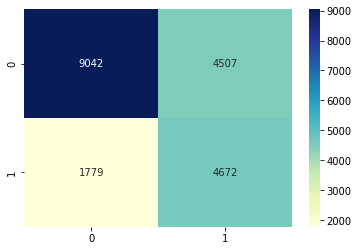

In [152]:
# Random Forest 평가점수
get_clf_eval(y_valid, rdn_clf.predict_proba(X_valid)[:,1]>0.32)

In [122]:
# 2. XGBoost
xgb_clf = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor',
                        objective='binary:logistic', nthread=-1,
                        random_state=42)
# GPU사용시ㅡ tree_method='gpu_hist' 
# Do not use this for test/validation tasks as some information may be lost in quantisation. 
# This DMatrix is primarily designed to save memory in training from device memory inputs by avoiding intermediate storage. 

param_grid = {'max_depth':[6,8,10,12,14],                  # [5~10] -> 6
              'n_estimators':[200]         # [150~350]-> 200
              }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid, 
                          #  n_jobs=-1,
                           cv=cv,
                           scoring='accuracy', 
                           error_score=0) 

results_xgb=grid_search.fit(X_train, y_train)

results_xgb.best_params_

{'max_depth': 6, 'n_estimators': 200}

In [124]:
# XGB best parameter를 사용하여 prediction 수행
xgb_clf = XGBClassifier(max_depth = 6,
                        n_estimators = 200,
                        eval_metric='logloss', predictor='gpu_predictor',
                        objective='binary:logistic', nthread=-1,
                        random_state=42) 

xgb_clf.fit(X_train, y_train)

XGBClassifier(eval_metric='logloss', max_depth=6, n_estimators=200, nthread=-1,
              predictor='gpu_predictor', random_state=42)


정확도: 0.7294
정밀도: 0.5609
재현율: 0.7413
AUC: 0.7325
F1: 0.6386


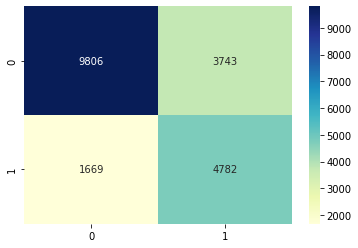

In [129]:
# XGB 평가점수
get_clf_eval(y_valid, xgb_clf.predict_proba(X_valid)[:,1]>0.32) #0.32:0.6386

In [130]:
# 3. Light GBM
lgbm_clf = LGBMClassifier()

param_grid = {'max_depth':[7],    #[5~17] -> 7
              'n_estimators':[250, 280, 300]  #[100~300] -> 280
              }

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=lgbm_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy', 
                           error_score=0) 

results=grid_search.fit(X_train, y_train)

results.best_params_

{'max_depth': 7, 'n_estimators': 300}

In [131]:
# LGBM best parameter를 사용하여 prediction 수행
lgbm_clf = LGBMClassifier(max_depth = 7,
                                n_estimators = 280,
                                eval_metric='logloss', random_state=42)

lgbm_clf.fit(X_train, y_train)

LGBMClassifier(eval_metric='logloss', max_depth=7, n_estimators=280,
               random_state=42)


정확도: 0.7263
정밀도: 0.5573
재현율: 0.7365
AUC: 0.7290
F1: 0.6345


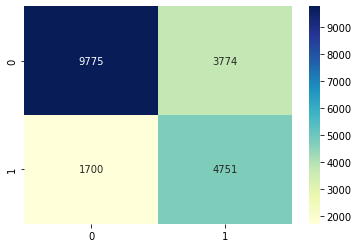

In [135]:
# LGBM 평가점수
get_clf_eval(y_valid, lgbm_clf.predict_proba(X_valid)[:,1]>0.32)  #0.32:0.6345

## 각 classifier의 feature 중요도

In [136]:
# Feature 중요도 구하기
def feat_importance(model, df):
    return pd.DataFrame({'cols':df.columns, 'imp':model.feature_importances_}).sort_values('imp', ascending=False)
#총 data 최대한 많이해서 구하는게 의미 있음 (99%)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.001, random_state=42)

In [86]:
rnd_clf = RandomForestClassifier(max_depth=16, n_estimators=250, random_state=42, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=16, n_estimators=250, n_jobs=-1,
                       random_state=42)

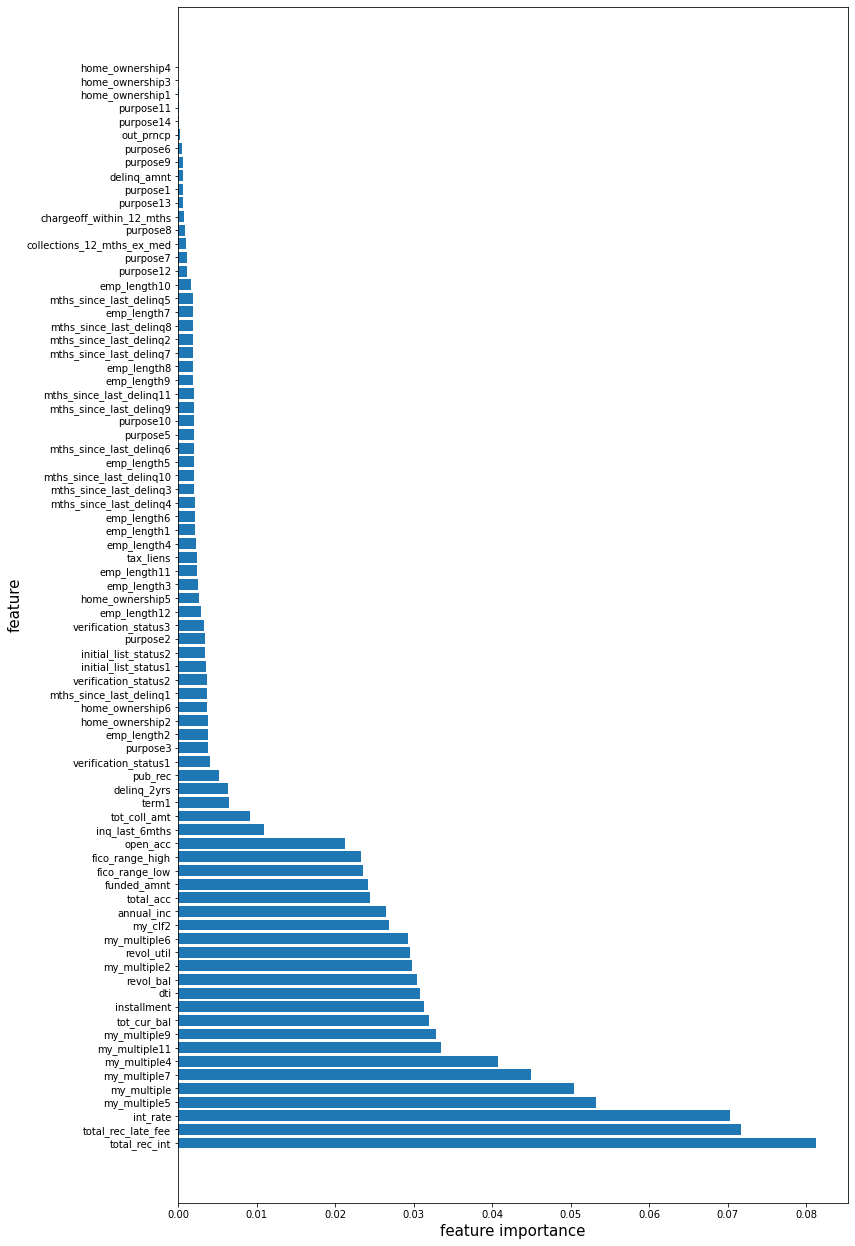

In [24]:
rnd_fi = feat_importance(rnd_clf, df.drop(columns=['depvar']))
# Feature importance 시각화
idx = np.arange(len(rnd_fi.cols))
plt.figure(figsize=(12, 22))
plt.barh(idx, rnd_fi.imp, align='center')
plt.yticks(idx, rnd_fi.cols)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()


정확도: 0.7303
정밀도: 0.5862
재현율: 0.5573
AUC: 0.6850
F1: 0.5714


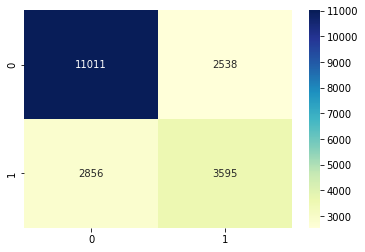

In [85]:
get_clf_eval(y_valid, rnd_clf.predict_proba(X_valid)[:,1]>0.4)

In [137]:
lgbm_clf = LGBMClassifier(max_depth=6, n_estimators=200, random_state=42)
lgbm_clf.fit(X_train, y_train)

LGBMClassifier(max_depth=6, n_estimators=200, random_state=42)

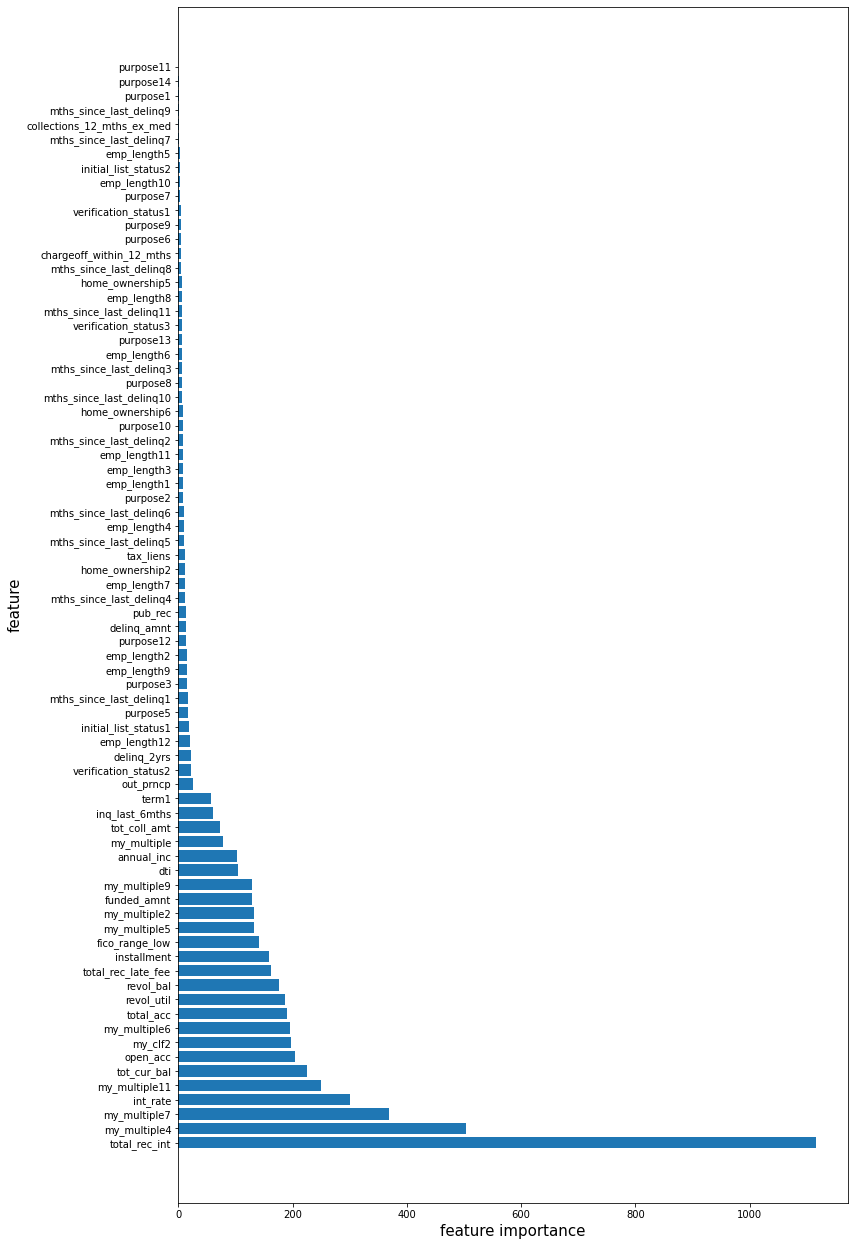

In [138]:
lgbm_fi = feat_importance(lgbm_clf, df.drop(columns=['depvar']))
# Feature importance 시각화
idx = np.arange(len(lgbm_fi.cols))
plt.figure(figsize=(12, 22))
plt.barh(idx, lgbm_fi.imp, align='center')
plt.yticks(idx, lgbm_fi.cols)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

In [139]:
xgb_clf = XGBClassifier(max_depth=7, n_estimators=250, 
                        objective='binary:logistic', nthread=-1,
                        random_state=42, tree_method='gpu_hist', predictor='gpu_predictor')
xgb_clf.fit(X_train, y_train, eval_metric='logloss')

XGBClassifier(max_depth=7, n_estimators=250, nthread=-1,
              predictor='gpu_predictor', random_state=42,
              tree_method='gpu_hist')

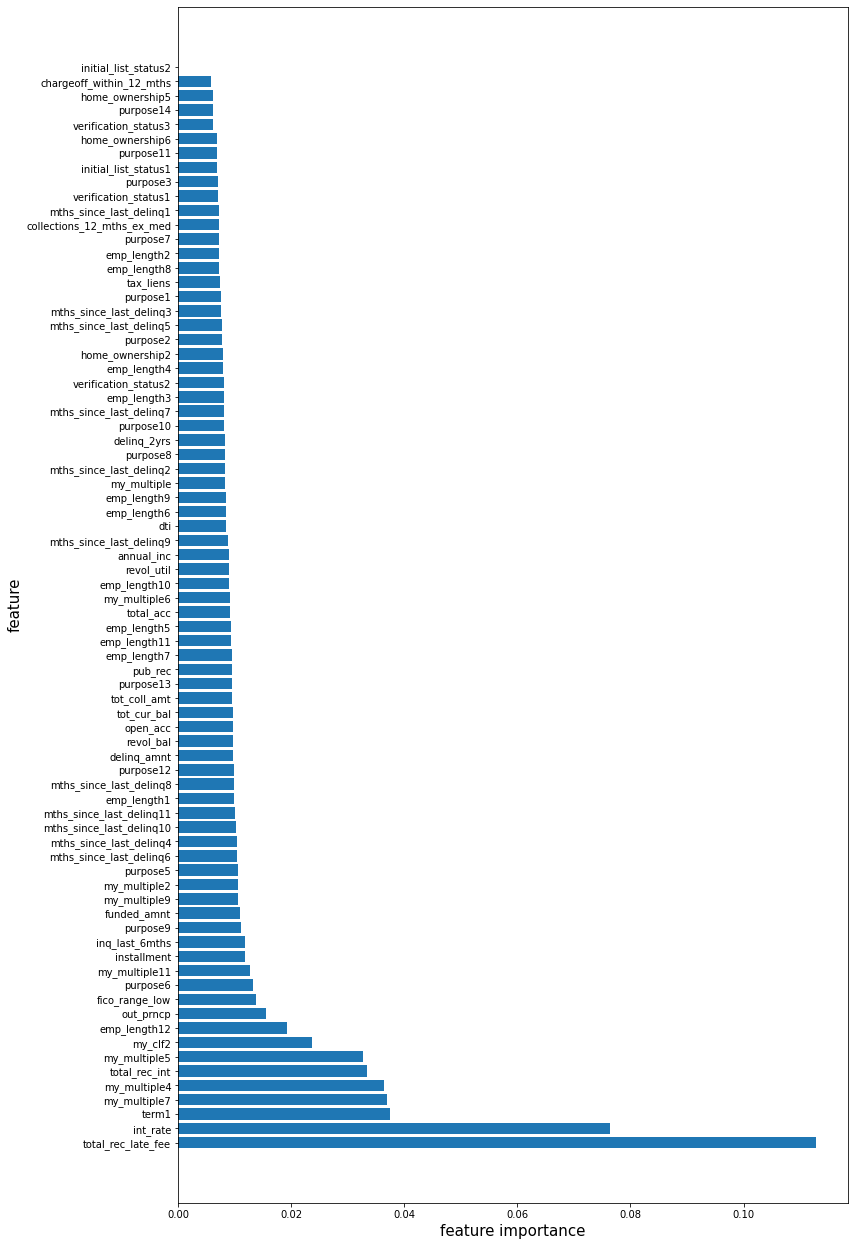

In [140]:
xgb_fi = feat_importance(xgb_clf, df.drop(columns=['depvar']))
# Feature importance 시각화
idx = np.arange(len(xgb_fi.cols))
plt.figure(figsize=(12, 22))
plt.barh(idx, xgb_fi.imp, align='center')
plt.yticks(idx, xgb_fi.cols)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()


정확도: 0.8100
정밀도: 0.6957
재현율: 0.8649
AUC: 0.8213
F1: 0.7711


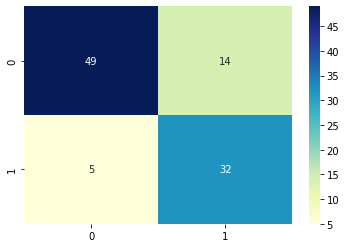

In [141]:
get_clf_eval(y_valid, xgb_clf.predict_proba(X_valid)[:,1]>0.3)

Optimal number of features : 55


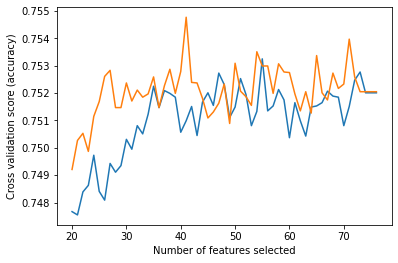

In [142]:
min_features_to_select = 20  # Minimum number of features to consider
rfecv = RFECV(
    estimator=xgb_clf,
    step=1,
    cv=StratifiedKFold(2),
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

Optimal number of features : 47


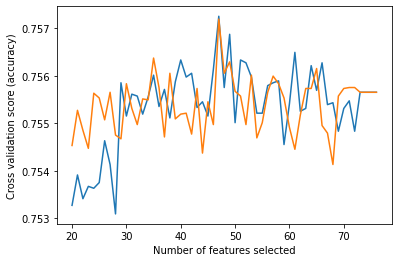

In [143]:
min_features_to_select = 20  # Minimum number of features to consider
rfecv = RFECV(
    estimator=lgbm_clf,
    step=1,
    cv=StratifiedKFold(2),
    scoring='accuracy',
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

## 앙상블 fitting

In [164]:
# 최적화 한걸로 ensemble 진행
rdn_clf = RandomForestClassifier(max_depth = 16,
                                n_estimators = 250,
                                min_samples_leaf=8,
                                min_samples_split=20,
                                ) 
lgbm_clf = LGBMClassifier(max_depth=6, n_estimators=200, objective='binary', random_state=42)
xgb_clf = XGBClassifier(max_depth=7, n_estimators=250, 
                        objective='binary:logistic', nthread=-1,
                        random_state=42, tree_method='gpu_hist', predictor='gpu_predictor')
# ext_clf = ExtraTreesClassifier(n_estimators = 200, min_samples_leaf=3, min_samples_split=4, random_state=42)

stacking_clf = StackingClassifier(estimators=[('rnd_clf', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier()) #('ext', ext_clf), 
stacking_clf.fit(X_train, y_train)

# soft_clf = VotingClassifier(estimators=[('rnd_clf', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], voting = 'soft') #('ext', ext_clf), 
# soft_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('rnd_clf',
                                RandomForestClassifier(random_state=42)),
                               ('lgbm',
                                LGBMClassifier(max_depth=6, n_estimators=200,
                                               objective='binary',
                                               random_state=42)),
                               ('xgb',
                                XGBClassifier(max_depth=7, n_estimators=250,
                                              nthread=-1,
                                              predictor='gpu_predictor',
                                              random_state=42,
                                              tree_method='gpu_hist'))],
                   final_estimator=LGBMClassifier())

## validation 진행


정확도: 0.7177
정밀도: 0.5420
재현율: 0.8034
AUC: 0.7401
F1: 0.6473


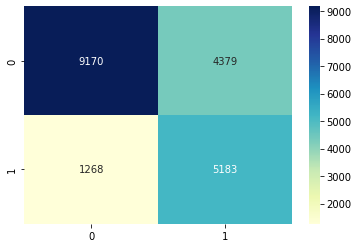

In [169]:
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.30)     # 0.6439 -> 0.6405
# get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.35)  #0.6403 -> 0.6376
get_clf_eval(y_valid, stacking_clf.predict_proba(X_valid)[:,1]>0.32)   #0.6473

# 데이터 비율 9:1
# LGBM기본 + 랜덤포레스트제외 + 내부함수 최적화된값 = 0.6433
# LGBM기본 + 랜덤포레스트포함 + 내부함수 최적화된값 = 0.6426

# 데이터 비율 8:2
# final_estimator = LGBM :0.6431 /  LGBM최적화:0.6419 / XGB :6411 / XGB최적화 : 0.6373
# XGB최적화 : 0.6373 + 랜덤포레스트 제외 = 0.6384
# LGBM기본 + 랜덤포레스트제외 + 내부함수 최적화된값 = 0.6414

# 기본피처들만 사용 + 컬럼 필요없는것 3개 삭제 = 0.6363
# 완전 기본 데이타 = 0.6363 별차이없네
# 새로운피처 추가(카테고리형 제외) = 0.6426(최대값) -> 결론 : 새로운 피처가 성능향상에 도움은 됨
# 피처 6개 + 컬럼 필요없는것 3개 삭제 = 0.6425(최대값) -> 결론 : 컬럼 삭제는 조금이지만 성능을 아주조금 내리는 것같음. 일단 의미없는 수준
# 피처 6개 + 컬럼 필요없는것 3개 삭제 + 마지막 확률 피쳐 넣었을 떄 = 0.6424(최대값) -> 범위설정해주는것떄문에 조금 떨어지는건가
# 위에서 범위설정해주는 항목만 삭제 + groupby에서도 제외 = 0.6417 -> 결국은 저 feature도 도움은 된다는것
# 모든거 설정한 상태에서 소프트 보팅으로 전환 -> 0.6374가 최대 그냥 stacking이 젤 좋은걸로

# 근데 위 실험은 각 classfication이 다른 dataset에 대해 각각 최적화된게 아니라 하나로 진행한거라 아주 정확하진 않음. 그냥 큰편에서 생각하는걸로

## 제출

In [171]:
# 제출 양식 다운로드
df_test = pd.read_csv('/content/drive/MyDrive/competition_1st/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/competition_1st/sample_submission.csv')
df_test = df_test.drop(['out_prncp_inv', 'funded_amnt_inv', 'acc_now_delinq', 'purpose4', 'fico_range_high', 'home_ownership1', 'home_ownership3', 'home_ownership4'], axis=1)
df_test = df_test.drop(['chargeoff_within_12_mths', 'purpose11', 'purpose14', 'purpose6'], axis=1)

# test파일에도 위에서 했던 전처리 진행
df_test['my_ft1'] = df_test['int_rate']*df_test['dti']
df_test['my_ft2'] = np.log(df_test['annual_inc']*df_test['fico_range_low'])
df_test['my_ft4'] = df_test['int_rate']*df_test['funded_amnt']
df_test['my_ft5'] = df_test['int_rate']*df_test['dti']/np.log(df_test['tot_cur_bal']*df_test['fico_range_low'])
df_test['my_ft6'] = df_test['revol_util']/(df_test['revol_bal']+0.0000001)
df_test['my_ft7'] = df_test['int_rate']*df_test['funded_amnt']/np.log(df_test['tot_cur_bal']*df_test['fico_range_low']+2)
df_test['my_ft9'] = np.log(df_test['int_rate']*df_test['funded_amnt'])*df_test['dti']
df_test['my_ft11'] = df_test['installment']/ df_test['annual_inc']
df_test.loc[df['collections_12_mths_ex_med'] <= 0.1, 'collections_12_mths_ex_med'] = 0   # 0번 추심 발생횟수
df_test.loc[df['collections_12_mths_ex_med']  > 0.1, 'collections_12_mths_ex_med'] = 1   # 1번 이상 추심 발생횟수
df_test['my_ft13'] = df.groupby([df.term1, df.emp_length12, df.home_ownership6, df.verification_status3, df.initial_list_status1, df.collections_12_mths_ex_med, df.initial_list_status2])['depvar'].transform('mean')
df_test['my_ft14'] = df_test['total_rec_int']/df_test['installment']
df_test['my_ft15'] = df_test['delinq_2yrs']+2*df_test['pub_rec']+3*df_test['inq_last_6mths']

submit['answer'] = stacking_clf.predict_proba(df_test.drop(columns=['ID']))[:,1]>0.34
change = {True:1, False:0}
submit.answer = submit.answer.map(change)
# 제출 파일 저장
submit.to_csv('/content/drive/MyDrive/competition_1st/submission_24.csv', index=False)